# Numerical check of the analytical results



## Import and define stuff

In [2]:
from __future__ import print_function
import numpy as np
import scipy
import time

% matplotlib inline 
import matplotlib.pyplot as plt
from imp import reload
import style as style; reload(style)
# colors = style.colors

tango_colors = [
    "#cc0000", # Scarlet Red 1
    "#2e3436", # Aluminium 5 (almost black)
    "#fcaf3e", # Orange 0
    "#a40000", # Scarlet Red 2
    "#204a87",  # Sky blue 2 
] 
colors = tango_colors

In [3]:
# Parameters

# Number of samples (for each point)
n_samples = 500

### Standard parameters for scans (if not altered)
# Network size
S       = 50
# Moments of distribution
mu      = 1.
sigma   = 1.
# Correlation 
rho     = 0

### Parameters to scan over

# Network sizes S
S_min   = 10
S_max   = 110
S_step  = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Correlations rho
rho_min  = -1.
rho_max  = 1
rho_step = 0.2
rhos = np.arange(rho_min, rho_max + rho_step, rho_step)

# Constant diagonal d_factor
d_factor_min  = 0.6
d_factor_max  = 1.4
d_factor_step = 0.1
d_factors = np.arange(d_factor_min, d_factor_max + d_factor_step, d_factor_step)

# Mean and standard deviation mus and sigmas
mu_min  = -0.5
mu_max  = 0.5
mu_step = 0.1
sigma_const = 0.5
mus = np.arange(mu_min, mu_max + mu_step, mu_step)
sigmas = np.repeat(sigma_const, mus.shape)


### Some helper functions

In [4]:
# Two lines in legend: 
# From 
# http://stackoverflow.com/questions/31544489/two-line-styles-in-legend?rq=1

from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D


class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = ((height) / (numlines + 1)) * np.ones(xdata.shape, float)
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines
    
# ### Example use case
# # Need to make proxy artists:
# # Make list of one line -- doesn't matter what the coordinates are
# line = [[(0, 0)]]
# # Set up the line collections
# lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = ['black', 'black'])
# # Create the legend
# plt.legend([lc], ['text',], handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)


### Now the same thing for two points:
# http://stackoverflow.com/questions/31478077/how-to-make-two-markers-share-the-same-label-in-the-legend-using-matplotlib
class AnyObject(object):
    pass
class data_handler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        scale = fontsize / 22
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch_sq = mpatches.Rectangle([x0, y0 + height/2 * (1 - scale) ], height * scale, height * scale, facecolor='0.5',
                edgecolor='0.5', transform=handlebox.get_transform())
        patch_circ = mpatches.Circle([x0 + width - height/2, y0 + height/2], height/2 * scale, facecolor='none',
                edgecolor='black', transform=handlebox.get_transform())

        handlebox.add_artist(patch_sq)
        handlebox.add_artist(patch_circ)
        return patch_sq

# Use case
# ...
# ax.legend([AnyObject(), m1[0]], ['Data', 'Model'], handler_map={AnyObject: data_handler()})


# Third thing: Again two points next to each other
# http://stackoverflow.com/questions/18007022/two-unique-marker-symbols-for-one-legend?noredirect=1&lq=1
from matplotlib.legend_handler import HandlerLine2D

class HandlerXoffset(HandlerLine2D):
    def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
        HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
        self._xoffset = x_offset
    def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
        numpoints = self.get_numpoints(legend)

        if numpoints > 1:
            # we put some pad here to compensate the size of the
            # marker
            xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                width - self._marker_pad * fontsize,
                                numpoints) - self._xoffset
            xdata_marker = xdata
        elif numpoints == 1:
            xdata = np.linspace(-xdescent, width, 2) - self._xoffset
            xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]

        return xdata, xdata_marker

# time_model = time_model_sec = time_obs = time_obs_apg = time_obs_apg_sec = range(5)

# rv_model_primary = np.random.rand(5)
# rv_model_secondary = np.random.rand(5)
# rv_obs_primary = np.random.rand(5)
# rv_obs_primary_apg =  np.random.rand(5)
# rv_obs_secondary_apg =  np.random.rand(5)

# p1,=plt.plot(time_model, rv_model_primary, 'k-')
# p2,=plt.plot(time_model_sec, rv_model_secondary, 'k--')
# p3,=plt.plot(time_obs, rv_obs_primary, 'bo')
# p4,=plt.plot(time_obs_apg, rv_obs_primary_apg, 'ro')
# p5,=plt.plot(time_obs_apg_sec, rv_obs_secondary_apg, 'rs')

# plt.legend([p1,p2,p3,(p5,p4)], 
#            ["Primary", "Secondary", "XYZ", "This Work"],
#             handler_map={p4:HandlerXoffset(x_offset=10),   
#                          p5:HandlerXoffset(x_offset=-10)})

In [5]:
# Get critical d
def get_d_c(S, mu, sigma, rho):
    # Calculate critical d
    if mu > 0:
        d_c = (S - 1) * mu  
    else:
        d_c = np.sqrt(S * sigma**2 * (1 + rho)) - mu
    return d_c


def plot_results(
    errs, 
    mean_theo_f, 
    std_theo_f,
    xs, 
    xlabel, 
    show_legend=False, 
    figsize=(6, 4), 
    **kwargs
):
    if 'xlim' in kwargs.keys():
        xlim = kwargs['xlim']
    else:
        dx  = 0.1 * (max(xs) - min(xs))
        xlim = (min(xs) - dx, max(xs) + dx)
    if 'ylim' in kwargs.keys():
        ylim = kwargs['ylim']
    else:
        dy  = 0.1 * (np.max(errs) - np.min(errs))
        ymin = np.min((0., np.min(errs))) - dy
        ymax = np.max((0., np.max(errs))) + dy
        ylim = (ymin, ymax)
    
    fig = plt.figure(figsize=figsize)
    ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

    # Zero line
    ax.axhline(0, linestyle='-', color='k')
    
    # Single errors
    err0,   = ax.plot(xs, errs[:, 0], 'o', ms=1.5, color=colors[0])
    ax.plot(xs, errs[:, 1:], 'o', ms=1.5, color=colors[0])

    # Empirical means and std devs
    means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)
    mum,    = ax.plot(xs, means,          'o', ms=5, color=colors[1], zorder=6, label=r"$\mu_{err}$")
    stdm,   = ax.plot(xs, means + stds,   '_', ms=8, mew=2, mec=colors[1], zorder=5, 
                      label=r"$\pm \sigma_{err} + \mu_{err}$")
    ax.plot(xs, means - stds,   '_', ms=8, mew=2, mec=colors[1], zorder=5)
    
    # Theoretical means and std devs
    xs_c        = np.linspace(xlim[0], xlim[1], 200)
    mean_theo   = mean_theo_f(xs_c)
    std_theo    = std_theo_f(xs_c)
    ax.plot(xs_c, mean_theo, '-', color=colors[2], zorder=4, label=r"$\langle err \rangle$")
    ax.plot(xs_c, mean_theo + std_theo, 
            '--', color=colors[2], label=r"$\pm \mathrm{std}({err}) + \langle  err \rangle $")
    ax.plot(xs_c, mean_theo - std_theo, '--', color=colors[2])
    ax.fill_between(xs_c, mean_theo + std_theo, mean_theo - std_theo, color=colors[2], alpha=0.3)
    # Proxy artists for custom legend:
    line = [[(0, 0)]]
    lc = LineCollection(2 * line, lw=2., linestyles = ['solid', 'dashed'], colors = [colors[2], colors[2]])

    # Labels, etc
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$err$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if show_legend:
#         ax.legend(loc='best')
        from matplotlib.legend_handler import HandlerLine2D
        ax.legend([err0, (mum, stdm,), lc], 
                  ["$err_i$","$\mu_{err} \pm \sigma_{err}$", r"$\langle  err \rangle \pm \mathrm{std}({err}) $"], 
                  handler_map = {mum:       HandlerXoffset(x_offset=+10),
                                 stdm:      HandlerXoffset(x_offset=-10),
                                 type(lc):  HandlerDashedLines(),}, 
                  handlelength = 2.5, 
                 )
    style.fixticks(fig)
        
    if "fig_name" in kwargs.keys():
        fig_name = "error_GLV_" + kwargs["fig_name"]
        style.saving_fig(fig, figure_path='./figures', fig_name=fig_name, data_type='both')
    

## Scan over different networks sizes $S$

In [8]:
def compare_S(
    n_samples, Ss, mu, sigma, rho, 
    show_legend=False,
    conn= 1., 
    **kwargs
):
    if 'd_factor' in kwargs.keys():
        d_factor = kwargs["d_factor"]
        set_diagonal = True
    else:
        set_diagonal = False
        
    # Sample and calculate error
    errs = np.zeros((len(Ss), n_samples)) 
    for i, S in enumerate(Ss):
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            if set_diagonal:
                ### Adapt diagonal
                # `Critical` value for diagonals
                d_c         = get_d_c(S, mu, sigma, rho) 
                d           = d_c * d_factor
                np.fill_diagonal(A, -d)
                
            if conn < 1.:
                # Sparse backbone
                T = scipy.sparse.random(S, S, density=conn, data_rvs=scipy.stats.randint(0, 2).rvs).toarray()
                A *= T

            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den
            
    m_s = mu / sigma
    if conn == 1.:
        if set_diagonal:
            mean_theo_f = lambda S: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
            std_theo_f  = lambda S:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))
        else:
            mean_theo_f = lambda S: rho / (S * m_s**2) 
            std_theo_f  = lambda S: np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4))
    else:
        if set_diagonal:
            mean_theo_f = lambda S: d_factor**2 * (1 - conn) / (d_factor**2 - 2 * conn * d_factor + conn)
            std_theo_f  = lambda S: np.sqrt(conn * d_factor**4 * (1 - conn) * (1 - d_factor)**2 * (d_factor - 2 * conn + 1)**2 / 
                                            (S * (d_factor**2 - 2 * conn * d_factor + conn)**4 ))
        else:
            mean_theo_f = lambda S: rho / (S * m_s**2) 
            std_theo_f  = lambda S: np.sqrt(((1 - conn)**2 * m_s**4 
                                             + 2 * m_s**2 * (1 - conn + conn * rho) 
                                             + (1  - conn * rho)**2) / 
                                            (conn**2 * S**3 * m_s**4))
    
    # Plot results
    plot_results(
        errs, 
        mean_theo_f, 
        std_theo_f,
        xlabel  = r"Network size $S$", 
        xs      = Ss,
        xlim    = (0, np.max(Ss) + 10),
        ylim    = (-0.05, 0.05),
        show_legend=show_legend,
        **kwargs
    )
    
    return errs, mean_theo_f, std_theo_f, Ss

Save figure to ./figures/error_GLV_A_iid


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


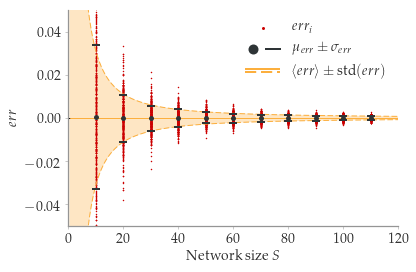

In [311]:
# Uncorrelated: A iid 
res1 = compare_S(n_samples, 
          Ss, 
          mu, 
          sigma, 
          rho=0., 
          show_legend=True, 
          fig_name = "A_iid",)
# Positive correlation
res2 = compare_S(n_samples, 
          Ss, 
          mu, 
          sigma, 
          rho=0.3,
          fig_name = "rho_03",)
# Negative correlation
res3 = compare_S(n_samples, 
          Ss, 
          mu, 
          sigma, 
          rho=-0.7,
          fig_name = "rho_-07",)
# Constant diagonal
res4 = compare_S(n_samples, 
          Ss, 
          mu, 
          sigma, 
          rho=0.,
          d_factor=2,
          fig_name = "d_2_rho_0",)



## Scan over different correlations $\rho$

In [12]:
def compare_rho(
    n_samples, S, mu, sigma, rhos, 
    show_legend=False,
    **kwargs
):
    if 'd_factor' in kwargs.keys():
        d_factor = kwargs["d_factor"]
        set_diagonal = True
    else:
        set_diagonal = False
        
    # Sample and calculate error
    errs = np.zeros((len(rhos), n_samples)) 
    for i, rho in enumerate(rhos):
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            if set_diagonal:
                ### Adapt diagonal
                # `Critical` value for diagonals
                d_c         = get_d_c(S, mu, sigma, rho) 
                d           = d_c * d_factor
                np.fill_diagonal(A, -d)

            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den
            
    m_s = mu / sigma
    if conn == 1.:
        if set_diagonal:
            mean_theo_f = lambda S: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
            std_theo_f  = lambda S:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))
        else:
            mean_theo_f = lambda S: rho / (S * m_s**2) 
            std_theo_f  = lambda S: np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4))
    else:
        mean_theo_f = lambda S: rho / (S * m_s**2) + (1 - conn**2) / (conn**2 * S)
        std_theo_f  = lambda S: (1 - conn**2) / (conn**2 * S)
    
    # Plot results
    plot_results(
        errs, 
        mean_theo_f, 
        std_theo_f,
        xlabel  = r"$\mathrm{corr}(A_{ij}, A_{ji}) = \rho$", 
        xs      = rhos,
        xlim    = (-1, 1),
        show_legend=show_legend,
        **kwargs
    )
    
    return errs, mean_theo_f, std_theo_f, rhos

Save figure to ./figures/error_GLV_vary_rho_no_d


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


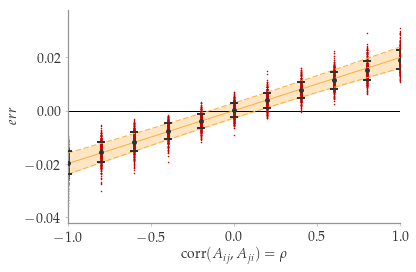

In [335]:
# Sample errors and plot results
res5 = compare_rho(n_samples, 
          S, 
          mu, 
          sigma, 
          rhos,
          fig_name = "vary_rho_no_d",)

## Scan over different constant diagonals

In [13]:
def compare_d_factor(
    n_samples, S, mu, sigma, rho, d_factors,
    show_legend=False,
    conn = 1., 
    **kwargs
):
    # Sample and calculate error
    errs = np.zeros((len(d_factors), n_samples)) 
    for i, d_factor in enumerate(d_factors):
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            ### Adapt diagonal
            # `Critical` value for diagonals
            d_c         = get_d_c(S, mu, sigma, rho) 
            d           = d_c * d_factor
            np.fill_diagonal(A, -d)
            
            if conn < 1.:
                # Sparse backbone
                T = scipy.sparse.random(S, S, density=conn, data_rvs=scipy.stats.randint(0, 2).rvs).toarray()
                A *= T

            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den
            
    assert conn == 1., "conn < 1 not realized"
    m_s = mu / sigma
    mean_theo_f = lambda d_factor: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
    std_theo_f  = lambda d_factor:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))
    
    # Plot results
    plot_results(
        errs, 
        mean_theo_f, 
        std_theo_f,
        xlabel  = r"Constant diagonal $- A_{ii} / d_c$", 
        xs      = d_factors,
        ylim    = (-1, 1),
        show_legend=show_legend,
        **kwargs
    )
    
    return errs, mean_theo_f, std_theo_f, d_factors

Save figure to ./figures/error_GLV_vary_d_rho_0


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


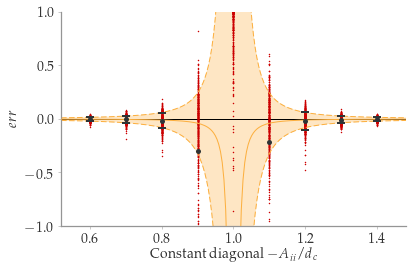

In [337]:
# Sample errors and plot results
res6 = compare_d_factor(n_samples, 
    S, 
    mu, 
    sigma, 
    rho,
    d_factors,
    fig_name = "vary_d_rho_0",)

## Scan over different ratios $\frac{\mu}{\sigma}$

In [10]:
def compare_mu_sigma(
    n_samples, S, mus, sigmas, rho, 
    show_legend=False,
    **kwargs
):
    if 'd_factor' in kwargs.keys():
        d_factor = kwargs["d_factor"]
        set_diagonal = True
    else:
        set_diagonal = False
        
    # Sample and calculate error
    errs = np.zeros((len(mus), n_samples)) 
    for i, mu_sigma in enumerate(np.stack((mus, sigmas), axis=1)):
        mu, sigma = mu_sigma
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            if set_diagonal:
                ### Adapt diagonal
                # `Critical` value for diagonals
                d_c         = get_d_c(S, mu, sigma, rho) 
                d           = d_c * d_factor
                np.fill_diagonal(A, -d)

            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den
            
    if set_diagonal:
        mean_theo_f = lambda m_s: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
        std_theo_f  = lambda m_s:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))
    else:
        mean_theo_f = lambda m_s: rho / (S * m_s**2)
        std_theo_f  = lambda m_s: np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4))
    
    ratios = mus / sigmas
    
    # Plot results
    plot_results(
        errs, 
        mean_theo_f, 
        std_theo_f,
        xlabel  = r"Ratio $\frac{\mu}{\sigma}$", 
        xs      = ratios, 
        ylim    = (-0.1, 0.1),
        show_legend=show_legend,
        **kwargs
    )
    
    return errs, mean_theo_f, std_theo_f, ratios

Save figure to ./figures/error_GLV_vary_mu_sigma_rho_0


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


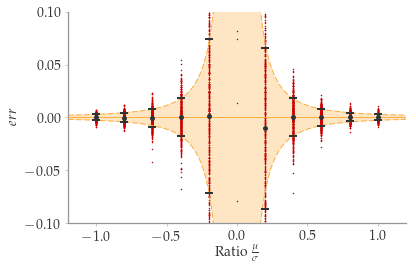

In [302]:
# Sample errors and plot results
res7 = compare_mu_sigma(n_samples, 
    S, 
    mus, 
    sigmas, 
    rho=0,
    fig_name = "vary_mu_sigma_rho_0",)

Save figure to ./figures/error_GLV_vary_mu_sigma_rho_02


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


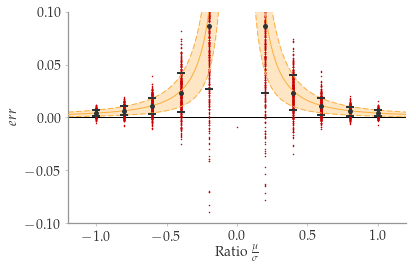

In [303]:
# Sample errors and plot results
res8 = compare_mu_sigma(n_samples, 
    S, 
    mus, 
    sigmas, 
    rho=0.2,
    fig_name = "vary_mu_sigma_rho_02",)

# Create panel 

In [19]:

def plot_single_res(
    ax, 
    errs, 
    mean_theo_f, 
    std_theo_f,
    xs, 
    xlabel, 
    show_legend=False, 
    **kwargs
):
    if 'xlim' in kwargs.keys():
        xlim = kwargs['xlim']
    else:
        dx  = 0.1 * (max(xs) - min(xs))
        xlim = (min(xs) - dx, max(xs) + dx)
    if 'ylim' in kwargs.keys():
        ylim = kwargs['ylim']
    else:
        dy  = 0.1 * (np.max(errs) - np.min(errs))
        ymin = np.min((0., np.min(errs))) - dy
        ymax = np.max((0., np.max(errs))) + dy
        ylim = (ymin, ymax)
    
    # Zero line
    ax.axhline(0, linestyle='-', color='#888a85')
    
    # Single errors
    err0,   = ax.plot(xs, errs[:, 0], 'o', ms=1.5, color=colors[0])
    ax.plot(xs, errs[:, 1:], 'o', ms=1.5, color=colors[0])

    # Empirical means and std devs
    means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)
    mum,    = ax.plot(xs, means,          'o', ms=5, color=colors[1], zorder=6, label=r"$\mu_{err}$")
    stdm,   = ax.plot(xs, means + stds,   '_', ms=8, mew=2, mec=colors[1], zorder=5, 
                      label=r"$\pm \sigma_{err} + \mu_{err}$")
    ax.plot(xs, means - stds,   '_', ms=8, mew=2, mec=colors[1], zorder=5)
    
    # Theoretical means and std devs
    xs_c        = np.linspace(xlim[0], xlim[1], 200)
    mean_theo   = mean_theo_f(xs_c)
    std_theo    = std_theo_f(xs_c)
    ax.plot(xs_c, mean_theo, '-', color=colors[2], zorder=4, label=r"$\langle err \rangle$")
    ax.plot(xs_c, mean_theo + std_theo, 
            '--', color=colors[2], label=r"$\pm \mathrm{std}({err}) + \langle  err \rangle $")
    ax.plot(xs_c, mean_theo - std_theo, '--', color=colors[2])
    ax.fill_between(xs_c, mean_theo + std_theo, mean_theo - std_theo, color=colors[2], alpha=0.3)
    # Proxy artists for custom legend:
    line = [[(0, 0)]]
    lc = LineCollection(2 * line, lw=2., linestyles = ['solid', 'dashed'], colors = [colors[2], colors[2]])

    # Labels, etc
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$err$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if show_legend:
#         ax.legend(loc='best')
        from matplotlib.legend_handler import HandlerLine2D
        ax.legend([err0, (mum, stdm,), lc], 
                  ["$err_i$","$\mu_{err} \pm \sigma_{err}$", r"$\langle  err \rangle \pm \mathrm{std}({err}) $"], 
                  handler_map = {mum:       HandlerXoffset(x_offset=+10),
                                 stdm:      HandlerXoffset(x_offset=-10),
                                 type(lc):  HandlerDashedLines(),}, 
                  handlelength = 2.5, 
                 )
        
from itertools import count
def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (-.2, 1.0),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='left', va='top')




    

Save figure to ./figures/error_GLV_panel


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


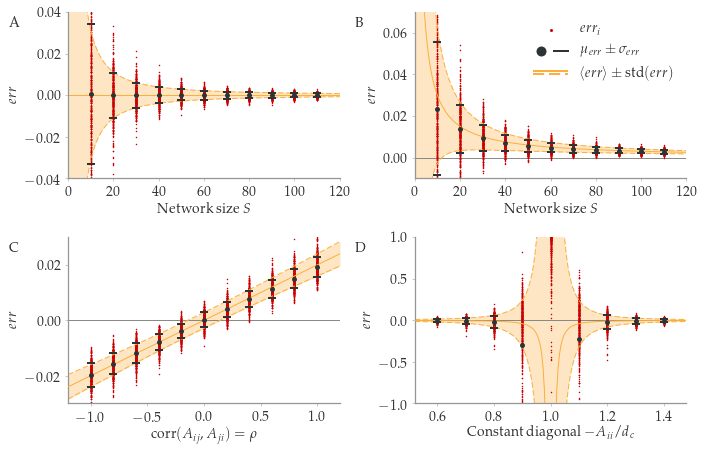

In [375]:
# Plot results
res_all = [
    res1, # iid
    res2, # rho = 0.3
    res5, # vary correlation
    res6, # vary const diag
]
show_leg = [True] + [False]*3

figsize = (10, 6.5) 
fig = plt.figure(figsize=figsize)
for i in range(2):
    for j in range(2):
        style.add_subplot(fig, n_rows_cols=(2, 2), index_row_col=(i, j), rowspan=1, colspan=1)

# A iid
errs, mean_theo_f, std_theo_f, Ss = res1
plot_single_res(
    fig.axes[0],
    errs, 
    mean_theo_f, 
    std_theo_f,
    xlabel  = r"Network size $S$", 
    xs      = Ss,
    xlim    = (0, np.max(Ss) + 10),
    ylim    = (-0.04, 0.04),
)
# rho = 0.3
errs, mean_theo_f, std_theo_f, Ss = res2
plot_single_res(
    fig.axes[1],
    errs, 
    mean_theo_f, 
    std_theo_f,
    xlabel  = r"Network size $S$", 
    xs      = Ss,
    xlim    = (0, np.max(Ss) + 10),
    ylim    = (-0.01, 0.07),
    show_legend=True,)

# Vary correlation
errs, mean_theo_f, std_theo_f, rhos = res5
plot_single_res(
    fig.axes[2],
    errs, 
    mean_theo_f, 
    std_theo_f,
    xlabel  = r"$\mathrm{corr}(A_{ij}, A_{ji}) = \rho$", 
    xs      = rhos,
#     xlim    = (-1, 1),
    ylim    = (-0.03, 0.03),
)

# Vary const diag
errs, mean_theo_f, std_theo_f, d_factors = res6
plot_single_res(
    fig.axes[3],
    errs, 
    mean_theo_f, 
    std_theo_f,
    xlabel  = r"Constant diagonal $- A_{ii} / d_c$", 
    xs      = d_factors,
    ylim    = (-1, 1),
#     ylim    = (-0.05, 0.05),
)

style.fixticks(fig)
label_subplots(fig.axes, upper_case=True)
fig_name = "error_GLV_panel"
style.saving_fig(fig, figure_path='./figures', fig_name=fig_name, data_type='both')


# Sparse matrices

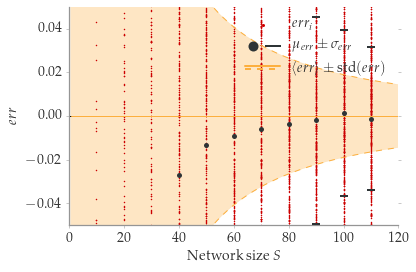

In [9]:
conn = 0.1
# Uncorrelated: A iid 
res1_sparse = compare_S(n_samples, 
                        Ss, 
                        mu, 
                        sigma, 
                        rho=0., 
                        show_legend=True, 
                        conn=conn,
#                         fig_name = "A_iid_sparse",
                       )

In [20]:
conn = 0.12
# Uncorrelated: A iid 
res1_sparse = compare_S(n_samples, 
                        Ss, 
                        mu, 
                        sigma, 
                        rho=0., 
                        show_legend=True, 
                        conn=conn,
#                         fig_name = "A_iid_sparse",
                       )
# Positive correlation
res2_sparse = compare_S(n_samples, 
                        Ss, 
                        mu, 
                        sigma, 
                        rho=0.3, 
                        conn=conn,
#                         fig_name = "rho_03_sparse",
                       )
# Negative correlation
res3_sparse = compare_S(n_samples, 
                        Ss, 
                        mu, 
                        sigma, 
                        rho=-0.7, 
                        conn=conn,
#                         fig_name = "rho_-07_sparse",
                       )
# # Constant diagonal
# res4_sparse = compare_S(n_samples, 
#                         Ss, 
#                         mu, 
#                         sigma, 
#                         rho=0.,
#                         d_factor=2,
#                         conn=conn,
# #                         fig_name = "d_2_rho_0_sparse",
#                        )
# Vary rho (no correlation, no diag)
res5_sparse = compare_rho(n_samples, 
                          S, 
                          mu, 
                          sigma, 
                          rhos,
                          conn=conn,
#                           fig_name = "vary_rho_no_d_sparse",
                         )
# # Vary constant diag (no correlation)
# res6_sparse = compare_d_factor(n_samples, 
#                                S, 
#                                mu, 
#                                sigma, 
#                                rho,
#                                d_factors,
#                                conn=conn,
# #                                fig_name = "vary_d_rho_0_sparse",
#                               )

NameError: name 'C' is not defined

In [318]:
raise Exception("Don't run the cells below...")

Exception: Don't run the cells below...

## $A_{ij} > 0 \sim$ log-normal, iid

The log-normal distribution has the following moments:

> $ \mu_l      = e^{\mu +\sigma ^{2}/2} $ 
 
> $ \sigma_l^2 = (e^{\sigma ^{2}}\!\!-1)e^{2\mu +\sigma ^{2}} $

> $ \mu_{l, 3} = (e^{\sigma ^{2}}\!\!+2){\sqrt {e^{\sigma ^{2}}\!\!-1}} \cdot \sigma_l^3 $

> $ \mu_{l, 4} = (e^{4\sigma ^{2}}\!\!+2e^{3\sigma ^{2}}\!\!+3e^{2\sigma ^{2}}\!\!-3) \cdot \sigma_l^4 $

where $\mu$ and $\sigma$ are the mean and variance of the underlying normal distribution.


In [ ]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Mean and variance of underlying gaussian
mu_normal       = 0.
sigma_normal    = 1.

# Moments of actual distribution
mu      = np.exp(mu_normal + sigma_normal**2 / 2.)
sigma   = np.sqrt((np.exp(sigma_normal**2) - 1.) * np.exp(2 * mu_normal + sigma_normal**2))
mu_3    = (np.exp(sigma_normal**2) + 2) * np.sqrt(np.exp(sigma_normal**2) - 1.) * sigma**3
mu_4    = (np.exp(4 * sigma_normal**2) + 2 * np.exp(3 * sigma_normal**2) + 3 * np.exp(2 * sigma_normal**2) - 3) * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.lognormal(mean=mu_normal, sigma=sigma_normal, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

## Worst case scenario: zero mean 

In [ ]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Moments of distribution
mu      = 0.
sigma   = 1.
mu_3    = 0. * sigma**3
mu_4    = 3. * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

# Correlated opposites

In [ ]:


def get_corr_normal_A(mu, sigma, S, rho):
    # Sample A
    A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

    # Correlate off-diagonal elements
    for i in range(S):
        for j in range(i + 1, S):
            A[j, i] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[i, j] + np.sqrt(1 - rho**2) * A[j, i]
            
    return A

# Test: Plot correlate elements
mu = 1.
sigma = 0.5
S = 100
rho = -0.5

A = get_corr_normal_A(mu, sigma, S, rho)
xs = []
for i in range(S):
    for j in range(i + 1, S):
        xs.append([A[i, j], A[j, i]])
xs= np.asarray(xs)        

# Plotting
fig = plt.figure(figsize=figsize)
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

ax.scatter(xs[:, 0], xs[:, 1])


In [ ]:

#     # Printing results
#     print("size S        mean(err)_measured   std(err)_theo  std(err)_measured")
#     for mean, S , std in zip(means, Ss, stds):
#         if mean < 0:
#             print("%6d        %.6f            %.6f       %.6f"%(S, mean, std_theo(S), std))
#         else:
#             print("%6d        %.6f            %.6f       %.6f"%(S, mean, std_theo(S), std))



In [ ]:

#     mu_3    = 0. * sigma**3
#     mu_4    = 3. * sigma**4
#     std_theo_full = lambda S:  np.sqrt((
#             (S**3 - S**2 - 3*S + 3) * sigma**4 + (S - 1) * mu_4) / (
#             S**6 * mu**4 + 6 * S**4 * sigma**2 * mu**2 + (S**3 + 2 * S**2 - 3 * S) * sigma**4 + 4 * S**2 * mu_3 * mu + S * mu_4))